In [1]:
# Import required libraries
import numpy as np
from scipy.linalg import expm, logm, sqrtm
import matplotlib.pyplot as plt
import h5py
import os
import seaborn as sns
import pandas as pd

# Working directories
script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = script_dir
graphs_dir = os.path.join(script_dir, 'Graphs/')

print(os.listdir(data_dir))

['N_6__m_8__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-06__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_2__multiE_no__geom_normal__sym_GPU__h1_1__h2_0', 'N_4__m_10__model_VHeis__ansatz_VHeis_multi__initZ_random-gaussian__errorC_phaseflip__p_err_1e-06__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_4__seed_4__multiE_no__geom_normal__sym_GPU', 'N_6__m_8__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-06__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_4__multiE_no__geom_normal__sym_GPU__h1_1__h2_0', 'N_6__m_8__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian__errorC_phaseflip__p_err_1e-06__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_3__multiE_no__geom_normal__sym_GPU__h1_1__h2_0', 'N_6__m_6__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian__errorC_phaseflip__p_err_1e-06__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-05__

In [2]:
def calculate_fidelity( rho,rho_target):
        '''
        Calculates the (Uhlmann-Jozsa) fidelity between the quantum circuit state and the target one.
        :param rho: density matrix of the current iteration state
        :return: the fidelity (double)
        '''
        w, v = np.linalg.eigh(rho_target)

        rho_target_sqrt = (v * np.sqrt(np.maximum(w, 0))).dot(v.conj().T)

        mat = np.matmul(np.matmul(rho_target_sqrt, rho), rho_target_sqrt)
        # F = np.trace(sqrtm(mat)) **2  # computed with different libraries, should give the same
        F = np.sum(np.sqrt(np.clip(np.linalg.eigh(mat)[0].real, 0, 1))) ** 2
        return F
def get_first_entry(data):
    if np.shape(data)[0] > 0 :
        return data[0] 
    elif isinstance(data, float):
        return data
    else:
        raise ValueError("Input must be a float or an array")
def read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,tol = 1e-5,initZ = "random-Gaussian-small",format="Kristina",sym_method = "CPU",h1 = 0,h2 = 0):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    elif format == "shortendtruncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "full":
        if h1 == 0 and h2 == 0: 
            grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_"+str(initZ)+'__errorC_'+str(error_channel)+'__p_err_'+str(p_err)+'__entropyM_'+str(entropy_method)+'__optimizer_'+ str(optimizer)+ '__tol_'+str(tol)+'__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal"+"__sym_" +str(sym_method)+"/")
        
        else: grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_"+str(initZ)+'__errorC_'+str(error_channel)+'__p_err_'+str(p_err)+'__entropyM_'+str(entropy_method)+'__optimizer_'+ str(optimizer)+ '__tol_'+str(tol)+'__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal"+"__sym_" +str(sym_method)+"__h1_"+str(h1)+"__h2_"+str(h2)+"/")
    elif format == "GPU_full":
        grid_dir = os.path.join(data_dir, f'N_{N}__m_{m}__model_{model}__ansatz_{ansatz}__initZ_random-gaussian-small__errorC_{error_channel}__p_err_{p_err}__entropyM_{entropy_method}__optimizer_L-BFGS-B__tol_'+str(tol)+'__nShots_None__seed_'+str(seed)+'__multiE_no__geom_normal__sym_GPU/')
    
    #elif format == "full":
    #    grid_dir = os.path.join(data_dir, f'N_{N}__m_{m}__model_{model}__ansatz_{ansatz}__initZ_random-gaussian-small__errorC_{error_channel}__p_err_{p_err}__entropyM_{entropy_method}__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_{seed}__multiE_False__geom_normal__sym_CPU/')

    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    files = []
    if os.path.exists(grid_dir):
        files = os.listdir(grid_dir)
        hdf5_files = [f for f in files if not f.endswith('.txt')]
        data = []
        print(grid_dir,hdf5_files)
        for file_num, filename in enumerate(hdf5_files): 
            f = h5py.File(grid_dir + str(filename), 'r')
            
            
            row = []
            for grp in f.keys():

                #settings = f[grp].attrs['Settings']
                #print(settings)
                print(grp)
                beta = grp
                
                #F_best = f[grp]['F'].attrs['F_best'] 
                #F_last = f[grp]['F'][:][-1]
                
                rho_target = f[grp]['rho_target'][:]
                rho_final = f[grp]['rho_final'][:]
                #Check no nans:
                if not np.any(np.isnan(rho_final)):
                    row.append(beta) 
                    row.append(N)
                    row.append(m)
                    row.append(model)
                    row.append(ansatz) 
                    row.append(error_channel) 
                    row.append(entropy_method) 
                    row.append(optimizer) 
                    row.append(n_epochs)
                    row.append(n_fev) 
                    row.append(seed) 
                    row.append(multierror) 
                    #row.append(float(F_best))
                    row.append(float(calculate_fidelity(rho_target,rho_final)))
            
                    S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
                    #print(S_cross)
                    S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
                    #print(S_target)
                    S_cross_scaled = S_cross / S_target
                    S_cross_diff = np.abs(S_cross - S_target)
                    
                    row.append(float(S_cross_scaled))
                    row.append(float(S_cross_diff))
                    #print(S_cross_scaled)
                    #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                        
                    #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
                    #print(S_HS)
                    
                    TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
                    
                    row.append(np.real(TD))
                    
                    row.append(np.shape(f[grp]['G'][:])[0])
                    #row.append(f[grp]["G"][-1])
                    if len(f[grp]["G"]) > 0:
                        row.append(get_first_entry(f[grp]["G"][-1]))
                    else:
                        # Handle the case when the dataset is empty
                        row.append(None) 
                    row.append(h1)
                    if h2:
                        row.append(h2)
                    else: row.append(0)
                    """Beta_arr
                    if not f[grp]["G"]:
                        row.append(f[grp]["G"][-1])
                    else:
                        row.append(0)
                    """

                    data.append(row)
        if not data: return None
        print(data)
        df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror','F', 'S_cross', 'S_cross_diff', 'TD',"Nit","FinalCost","h1","h2"])#
        return df
    else: 
            print(f"Directory {grid_dir} does not exist.")

    
            
    


In [3]:

def create_data_frame(frames):
        df = pd.concat(frames, ignore_index=True)

        df['beta']= df['beta'].astype(float)
        df['N']= df['N'].astype(int)
        df['m']= df['m'].astype(int)
        df['model']= df['model'].astype(str)
        df['ansatz']= df['ansatz'].astype(str)
        df['error_channel']= df['error_channel'].astype(str)
        df['entropy_method']= df['entropy_method'].astype(str)
        df['optimizer']= df['optimizer'].astype(str)
        df['n_epochs']= df['n_epochs'].astype(str)
        df['n_fev']= df['n_fev'].astype(str)
        df['seed']= df['seed'].astype(int)
        df['multierror']= df['multierror'].astype(str)
        df['F']= df['F'].astype(float)
        df['S_cross']= df['S_cross'].astype(float)
        
        df['S_cross_diff']= df['S_cross_diff'].astype(float)
        df['TD']= df['TD'].astype(float)
        df['Nit']= df['Nit'].astype(float)
        df['FinalCost']= df['FinalCost'].astype(float)
        df["h1"]=df['h1'].astype(float)
        df["h2"]=df['h2'].astype(float)

        return df

In [4]:
unique_h1_values = [1]#[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
unique_h2_values = "None"

beta_arr =  [  0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#[  0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#


frames = []
#N_6__m_3__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_0.01__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_2__multiE_no__geom_normal__sym_CPU__h1_-1__h2_0
N_list = [6]
m_list = [6,8]
model_list = ["TFIM"]
ansatz_list = ["TFIM-trotter","sym_TFIM"]#,"TFIM-trotter",,#[::1]#,#"diydepol","TFIM-trotter","qaoa-r-layers",
error_channel_list = ["phaseflip"]
entropy_method_list = ["approx-D","exact"]
optimizer_list = ["L-BFGS-B"]
n_epochs_list = [50]
n_fev_list = [10000]
seeds = [1,2,3,4,5,6,7,8]#,3,4,5,6,7,8
multierror_list = ["no"]
initZ_arr = ["random-gaussian","random-gaussian-small"]
perr = 1e-6
tols = [1e-5,1e-6]#,0.0001,1e-6,1e-5
h2 = 0
sym_method =["GPU"]#


for N in N_list:
    for m in m_list:  
                for model in model_list:
                    for ansatz in ansatz_list:
                        for error_channel in error_channel_list:
                            for entropy_method in entropy_method_list:
                                for optimizer in optimizer_list:
                                    for n_epochs in n_epochs_list:
                                        for n_fev in n_fev_list:
                                            for seed in seeds:
                                                for multierror in multierror_list:
                                                    for h1 in unique_h1_values:
                                                        for tol in tols:
                                                                for sym in sym_method:
                                                                    for initZ in initZ_arr:
                                                                        #print(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,p_err = perr,tol = tol,initZ=initZ,format = "full",sym_method=sym_method,h1 = h1,h2 = h2))     
                                                                        print(ansatz)
                                                                        frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,p_err = perr,tol = tol,initZ=initZ,format = "full",sym_method=sym,h1 = h1,h2 = h2))
                                                        
   
df = create_data_frame(frames)
df
#N_6__m_6__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian__errorC_phaseflip__p_err_1e-06__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_2__multiE_no__geom_normal__sym_CPU__h1_1__h2_0
#N_6__m_6__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian__errorC_phaseflip__p_err_1e-06__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_1__multiE_no__geom_normal__sym_CPU__h1_-1__h2_0

TFIM-trotter
/Users/eliaszap/polybox - Elias Zapusek (zapuseke@phys.ethz.ch)@polybox.ethz.ch/Phd/QML/VQT/VQT/Fig6 TFIM/N_6__m_6__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian__errorC_phaseflip__p_err_1e-06__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_1__multiE_no__geom_normal__sym_GPU__h1_1__h2_0/ ['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
6.69
3.23
1.08
2.24
0.75
9.64
4.65
13.89
20.0
1.56
[['6.69', 6, 6, 'TFIM', 'TFIM-trotter', 'phaseflip', 'approx-D', 'L-BFGS-B', 50, 10000, 1, 'no', 0.21786086354965367, 53.55618193209547, 21.904747756077732, np.float64(0.8771454991673056), 0, None, 1, 0], ['3.23', 6, 6, 'TFIM', 'TFIM-trotter', 'phaseflip', 'approx-D', 'L-BFGS-B', 50, 10000, 1, 'no', 0.05176112939296555, 37.6882615150486, 22.914921593175116, np.float64(0.9719224348504727), 0, None, 1, 0], ['1.08', 6, 6, 'TFIM', 'TFIM-trotter', 'phaseflip', 'approx-D', 'L-BFGS-B', 50, 10000, 1, 'no', 0.046240991

,beta,N,m,model,ansatz,error_channel,entropy_method,optimizer,n_epochs,n_fev,seed,multierror,F,S_cross,S_cross_diff,TD,Nit,FinalCost,h1,h2
0,6.69,6,6,TFIM,TFIM-trotter,phaseflip,approx-D,L-BFGS-B,50,10000,1,no,0.217861,53.556182,21.904748,0.877145,0.0,NaN,1.0,0.0
1,3.23,6,6,TFIM,TFIM-trotter,phaseflip,approx-D,L-BFGS-B,50,10000,1,no,0.051761,37.688262,22.914922,0.971922,0.0,NaN,1.0,0.0
2,1.08,6,6,TFIM,TFIM-trotter,phaseflip,approx-D,L-BFGS-B,50,10000,1,no,0.046241,7.816294,10.324214,0.967655,0.0,NaN,1.0,0.0
3,2.24,6,6,TFIM,TFIM-trotter,phaseflip,approx-D,L-BFGS-B,50,10000,1,no,0.036216,31.601119,22.646337,0.980133,0.0,NaN,1.0,0.0
4,0.75,6,6,TFIM,TFIM-trotter,phaseflip,approx-D,L-BFGS-B,50,10000,1,no,0.112479,3.059993,4.648194,0.917928,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,9.64,6,8,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,4,no,0.936501,0.337269,0.173561,0.072918,47.0,-74.486446,1.0,0.0
336,4.65,6,8,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,4,no,0.802846,0.542236,0.245741,0.225736,30.0,-35.927825,1.0,0.0
337,13.89,6,8,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,4,no,0.977016,0.287003,0.083753,0.025733,52.0,-107.317519,1.0,0.0
338,20.00,6,8,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,4,no,0.995602,0.403657,0.019204,0.008999,51.0,-154.525865,1.0,0.0


/var/folders/qd/5q9cvk1x2lgcx1ddzjm2j60c0000gn/T/ipykernel_94486/4270528076.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_max['nonunitary'].replace({'sym_TFIM': 'Phaseflip', 'TFIM-trotter': r'$L = Z + q Y$'}, inplace=True)
/var/folders/qd/5q9cvk1x2lgcx1ddzjm2j60c0000gn/T/ipykernel_94486/4270528076.py:14: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data = df_max[(df_max['m'] == 8) & (df_max['entropy_method'] == "exact")], x = 'beta', y ='F', style="nonun

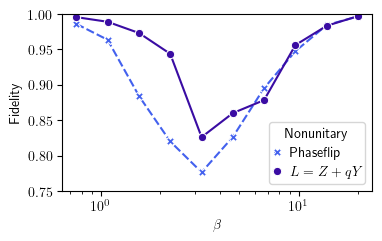

In [5]:
df1 = df.fillna(1e6)
beta_arr = [6.69, 3.23, 1.08, 2.24, 0.75, 9.64, 13.89, 20.0, 1.56]  # Adjust as needed
df_max = df1.loc[df1.groupby(['beta', 'ansatz',"N","m","entropy_method"])['FinalCost'].idxmin()]
df_max = df_max[df_max['beta'].isin(beta_arr)]

palette = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]
plt.rcParams['text.usetex'] = True
df_max = df1.loc[df1.groupby(['beta', 'ansatz',"m","N","entropy_method"])['F'].idxmax()]
df_max.rename(columns={'ansatz': 'nonunitary'}, inplace=True)
df_max['nonunitary'].replace({'sym_TFIM': 'Phaseflip', 'TFIM-trotter': r'$L = Z + q Y$'}, inplace=True)


plt.figure(figsize=(4,2.3))
sns.lineplot(data = df_max[(df_max['m'] == 8) & (df_max['entropy_method'] == "exact")], x = 'beta', y ='F', style="nonunitary",hue = "nonunitary",hue_order=["Phaseflip",r'$L = Z + q Y$'], markers=True,palette=[palette[3],palette[2],palette[1],palette[4]])
plt.xscale('log')
plt.ylim(0.75,1)

plt.legend(title='Nonunitary',borderpad = 0.4,handlelength = 0.3)#, labels=['Phaseflip',r'$L = Z + q Y$']

# or', r'$Z$'])
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

filename = "TFIM_exact.pdf"
plt.savefig(filename, bbox_inches='tight', facecolor=(1,1,1,0))
plt.show()


Plotting Vheis